In [1]:
import spacy
import textacy
import textacy.preprocessing
import textacy.resources
from spacy.symbols import ORTH, POS, NOUN, VERB,PRON
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt 
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from networkx.readwrite import json_graph;
import json
from afinn import Afinn
afn = Afinn()
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag
lemmatizer = WordNetLemmatizer()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('D:/github/causal-graph-acquisition/SentiStrengthCom.jar')
senti.setSentiStrengthLanguageFolderPath('D:/github/causal-graph-acquisition/SentStrength_Data_Sept2011/')
import pandas as pd
from IPython.display import display
import collections
from pd_replicator import replicator

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
from nltk.corpus import stopwords
set(stopwords.words('english'))

from nltk.stem import PorterStemmer
ps = PorterStemmer()

nlp = spacy.load("en_core_web_sm")

import inflect
m = inflect.engine()
from lemminflect import getInflection

from scipy.special import kl_div

import pysmile
pysmile.License((
	b"SMILE LICENSE c978699b 97c07af6 f69b7377 "
	b"THIS IS AN ACADEMIC LICENSE AND CAN BE USED "
	b"SOLELY FOR ACADEMIC RESEARCH AND TEACHING, "
	b"AS DEFINED IN THE BAYESFUSION ACADEMIC "
	b"SOFTWARE LICENSING AGREEMENT. "
	b"Serial #: damx5dd4ezqly012c37ko4l9i "
	b"Issued for: Solat Jabeen (solatjabeen@gmail.com) "
	b"Academic institution: Institute of Business Administration "
	b"Valid until: 2024-02-05 "
	b"Issued by BayesFusion activation server"
	),[
	0x73,0x67,0x28,0xba,0x6a,0x03,0x97,0x7f,0x5b,0x89,0x34,0xc7,0xc1,0x5a,0x5a,0xb3,
	0xec,0x9e,0x9e,0x6a,0x09,0xd5,0xc2,0x93,0xb4,0x57,0x24,0xc9,0x3d,0xf8,0x8d,0x25,
	0x96,0xbd,0x56,0xb8,0x3c,0xad,0x98,0x00,0xcb,0x27,0xa2,0x28,0x4b,0x1f,0x76,0xb1,
	0x92,0x1a,0x65,0x41,0xd6,0xbe,0x12,0xa3,0x4b,0x60,0x83,0x3f,0x57,0x1d,0xf7,0x23])

In [2]:
dagCauseSents = []

edge1 = './Text/Test_Smoking_CS.txt'
narrative = open(edge1, encoding="utf8").read()
narrative = textacy.preprocessing.normalize_quotation_marks(narrative)
narrative = narrative.lower()

raw_sentences = sent_tokenize(narrative)

print(len(raw_sentences))

for s in raw_sentences:
    dagCauseSents.append(s)

5


In [3]:
import csv 

dagCauseTriples = []
dagCauseVerbs = []

csv_filename = './Text/Test_Smoking_CT.txt'
with open(csv_filename) as f:
    reader = csv.reader(f)
    dagCauseTriples = list(tuple(line) for line in reader)
    
for s in dagCauseTriples:
    dagCauseVerbs.append(s[1])

In [4]:
for i,j,k in zip(dagCauseSents,dagCauseTriples,dagCauseVerbs):
    print(i,j,k)

smoking causes bronchitis. ('smoking', 'causes', 'bronchitis') causes
smoking causes lung cancer. ('smoking', 'causes', 'lung cancer') causes
bronchitis causes shortness of breath. ('bronchitis', 'causes', 'shortness of breath') causes
bronchitis causes fatigue. ('bronchitis', 'causes', 'fatigue') causes
lung cancer causes fatigue. ('lung cancer', 'causes', 'fatigue') causes


Nodes: 5
Edges: 5
smoking , bronchitis
smoking , lung cancer
bronchitis , shortness of breath
bronchitis , fatigue
lung cancer , fatigue


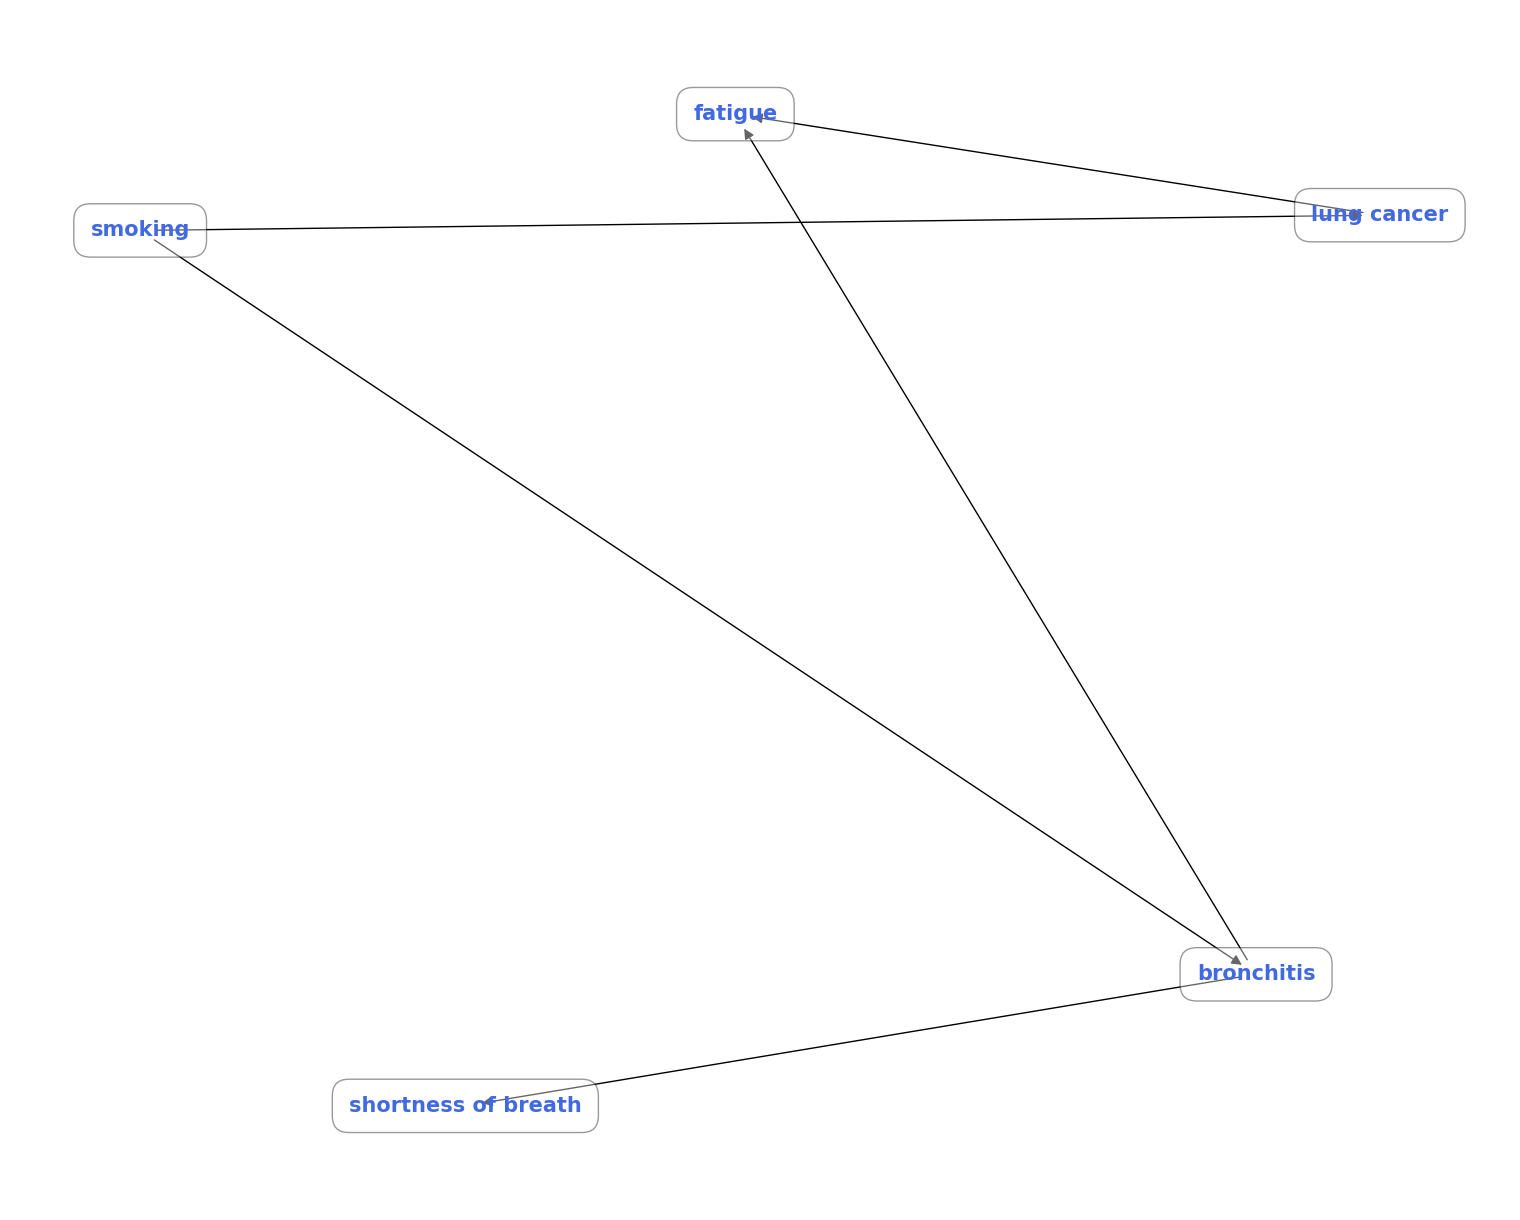

In [5]:
cg = nx.DiGraph()
cg.add_node("smoking",id = str("smoking"),title=str("smoking"),x=615,y=200)
cg.add_node("bronchitis",id = str("bronchitis"),title=str("bronchitis"),x=615,y=200)
cg.add_node("lung cancer",id = str("lung cancer"),title=str("lung cancer"),x=615,y=200)
cg.add_node("shortness of breath",id = str("shortness of breath"),title=str("shortness of breath"),x=615,y=200)
cg.add_node("fatigue",id = str("fatigue"),title=str("fatigue"),x=615,y=200)

cg.add_edge("smoking", "bronchitis")
cg.add_edge("smoking", "lung cancer")
cg.add_edge("bronchitis", "shortness of breath")
cg.add_edge("bronchitis", "fatigue")
cg.add_edge("lung cancer", "fatigue")


print("Nodes:",len(cg.nodes))
print("Edges:",len(cg.edges))

for e in cg.edges(data=True):
    print(e[0],",",e[1])

pos = nx.spring_layout(cg, k=4, iterations=20)
plt.figure(figsize=(15,12))

nx.draw(cg, pos=pos, with_labels=True,  node_shape="s",  node_color="none", font_size=15,  font_color='royalblue', font_weight='bold',bbox=dict(facecolor="white", alpha=0.4,boxstyle='round,pad=0.8'),labels={node: node for node in cg.nodes()},arrows=True, arrowsize=15,width=1)
edge_labels = nx.get_edge_attributes(cg,'predicade')
nx.draw_networkx_edge_labels(cg, pos=pos, edge_labels = edge_labels, font_color='black',font_size=13)

plt.axis('off')
plt.show()

In [6]:
def Allen_sents_SentLevel(causalSentences):
    allen = []
    for sent in causalSentences:
        encoded_input = tokenizer(str(sent), return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        if scores[0] > scores[1] and scores[0] > scores[2]:
            score = scores[0] * -1
            score = round(score,3)
            allen.append(score)
            # allen.append(-1)
        elif scores[2] > scores[1] and scores[2] > scores[0]:
            scores[2] = round(scores[2],3)
            allen.append(scores[2])
            # allen.append(1)
        else:
            # allen.append(scores[1])
            allen.append(0)
    return allen

In [7]:
def Afinn_sents_SentLevel(causalSentences):
    afinn = []
    for sent in causalSentences:
        #print(sent)
        score = afn.score(str(sent))
        #print(score)
        if score < -5:
            score = -5
        elif score > 5:
            score = 5
        score = score/5
        score = round(score,3)
        afinn.append(score)
    return afinn

In [8]:
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    #print(vs)
    return vs['compound']

def Vader_sents_SentLevel(causalSentences):
    vader = []
    for sent in causalSentences:
        #print(sent)
        #vaderTup = []
        compound = vadersentimentanalysis(str(sent))
        compound = round(compound,3)
        vader.append(compound)
    return vader

In [9]:
def Senti_sents_SentLevel(causalSentences):
    sentiStrength = []
    for sent in causalSentences:
        #print(sent)
        result = senti.getSentiment(str(sent), score='scale')
        #print(result)
        result = result[0]/4
        result = round(result,3)
        sentiStrength.append(result)
    return sentiStrength

In [10]:
allen = Allen_sents_SentLevel(dagCauseSents)
afinn = Afinn_sents_SentLevel(dagCauseSents)
vader = Vader_sents_SentLevel(dagCauseSents)
sentiStrength = Senti_sents_SentLevel(dagCauseSents)

df_CSW = pd.DataFrame(list(zip(dagCauseSents, allen, afinn, vader,sentiStrength)), columns =['Causal Sentence', 'HuggingFace','Afinn','Vader','SentiStrength'])

df_CSW["Weight"] = df_CSW.sum(axis=1)

for i in df_CSW.index:
    count = 0
    if df_CSW["HuggingFace"][i] != 0:
        count = count + 1
    if df_CSW["Afinn"][i] != 0:
        count = count + 1
    if df_CSW["Vader"][i] != 0:
        count = count + 1
    if df_CSW["SentiStrength"][i] != 0:
        count = count + 1
    if count == 0:
        count = 1
    df_CSW["Weight"][i] = round(df_CSW["Weight"][i]/count,3)

sentPolarity = []
sentsWeight_sentLevel = []

for index, row in df_CSW.iterrows():
    sentWeightTuple = []
    weight = row['Weight']
    sentWeightTuple.append(weight)
    sentsWeight_sentLevel.append(sentWeightTuple)
    #print(weight)
    if weight >= -1 and weight < -0.6:
        sentPolarity.append('Strong Negative') 
    elif weight >= -0.6 and weight < -0.3:
        sentPolarity.append('Moderate Negative')
    elif weight >= -0.3 and weight < 0:
        sentPolarity.append('Weak Negative')
    elif weight == 0:
        sentPolarity.append('Neutral')
    elif weight <= 1 and weight > 0.6:
        sentPolarity.append('Strong Positive')
    elif weight <= 0.6 and weight > 0.3:
        sentPolarity.append('Moderate Positive')
    elif weight <= 0.3 and weight > 0:
        sentPolarity.append('Weak Positive')

df_CSW["Polarity"] = sentPolarity
df_CSW.style

C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
def GenerateTokens(causalSentences):
    marks = ['.',',','(',')','-',':',';','/',"'s",'_','__','--','"', '’', '—']
    tagsList = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    token_list = []
   
    for sent in causalSentences:
        tokens = word_tokenize(str(sent))
        tags = pos_tag(tokens)
        token_tuple = []
        for token,tag in tags:
            if str(token) not in marks:
                if str(token) not in stopwords.words() or tag in tagsList:
                    token_tuple.append(str(token))
        token_list.append(token_tuple)
    return token_list

In [12]:
def Allen_sents_TokenLevel(token_list):
    allen_word = []
    allen_tuple = []
    for tokenTuple in token_list:
        # print(tokenTuple)
        for token in tokenTuple:
            # print(token)
            encoded_input = tokenizer(str(token), return_tensors='pt')
            output = model(**encoded_input)
            scores = output[0][0].detach().numpy()
            scores = softmax(scores)
            if scores[0] > scores[1] and scores[0] > scores[2]:
                score = scores[0] * -1
                score = round(score,3)
                allen_tuple.append(score)
            elif scores[2] > scores[1] and scores[2] > scores[0]:
                scores[2] = round(scores[2],3)
                allen_tuple.append(scores[2])
            else:
                # allen_tuple.append(scores[1])
                allen_tuple.append(0)
        allen_word.append(allen_tuple)
        allen_tuple = []
    return allen_word

In [13]:
def Afinn_sents_TokenLevel(token_list):
    afinn_word = []
    afinn_tuple = []

    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            score = afn.score(str(token))
            if score < -5:
                score = -5
            elif score > 5:
                score = 5
            score = score/5
            score = round(score,3)
            afinn_tuple.append(score)
        afinn_word.append(afinn_tuple)
        afinn_tuple = []
    return afinn_word

In [14]:
def Vader_sents_TokenLevel(token_list):
    vader_word = []
    vader_tuple = []

    for tokenTuple in token_list:
        #print(sent)
        for token in tokenTuple:
            #if str(token) not in marks:
            vs = analyzer.polarity_scores(str(token))
            compound = vs['compound']
            compound = round(compound,3)
            vader_tuple.append(compound)
        vader_word.append(vader_tuple)
        vader_tuple = []
    return vader_word

In [15]:
def Senti_sents_TokenLevel(token_list):
    senti_word = []
    senti_tuple = []
    for tokenTuple in token_list:
        for token in tokenTuple:
            result = senti.getSentiment(str(token), score='scale')
                #print(result)
            result = result[0]/4
            result = round(result,3)
            senti_tuple.append(result)
        senti_word.append(senti_tuple)
        senti_tuple = []
    return senti_word

In [16]:
token_list = GenerateTokens(dagCauseSents)
allen_word = Allen_sents_TokenLevel(token_list)
afinn_word = Afinn_sents_TokenLevel(token_list)
vader_word = Vader_sents_TokenLevel(token_list)   
senti_word = Senti_sents_TokenLevel(token_list)

sum_list = []
sum_tup = []
limit= len(dagCauseSents)

for i in range(0,limit):
    for j in range(0,len(allen_word[i])):
        count = 0
        if afinn_word[i][j] != 0: 
            count = count +1
        if vader_word[i][j] != 0:
            count = count +1
        if senti_word[i][j] != 0:
            count = count +1
        if allen_word[i][j] != 0:
            count = count +1
        if count == 0:
            count = 1
        res = allen_word[i][j]+afinn_word[i][j]+vader_word[i][j]+senti_word[i][j]
        res = res/count
        res = round(res,3)
        sum_tup.append(res)
    sum_list.append(sum_tup)
    sum_tup = []
    
def DetectPolarity(sum_list):
    tokenPolarity = []
    tokenPolarity_list = []
    for s in sum_list:
        for weight in s:
            if weight >= -1 and weight < -0.6:
                tokenPolarity.append('Strong Negative') 
            elif weight >= -0.6 and weight < -0.3:
                tokenPolarity.append('Moderate Negative')
            elif weight >= -0.3 and weight < 0:
                tokenPolarity.append('Weak Negative')
            elif weight == 0:
                tokenPolarity.append('Neutral')
            elif weight <= 1 and weight > 0.6:
                tokenPolarity.append('Strong Positive')
            elif weight <= 0.6 and weight > 0.3:
                tokenPolarity.append('Moderate Positive')
            elif weight <= 0.3 and weight > 0:
                tokenPolarity.append('Weak Positive')
        tokenPolarity_list.append(tokenPolarity)
        tokenPolarity = []
    return tokenPolarity_list

tokenPolarity_list = DetectPolarity(sum_list)

sentsWeight_TokenLevel = []
weightSumTup = []
for t in sum_list:
    tripleWeight = 0
    total = 0
    for w in t:
        tripleWeight = tripleWeight + w
    tripleWeight = round(tripleWeight, 3)
    if tripleWeight > 1: 
        tripleWeight = 1
    if tripleWeight < -1:
        tripleWeight = -1
    weightSumTup.append(tripleWeight)
    sentsWeight_TokenLevel.append(weightSumTup)
    weightSumTup = []

SentencePolarity_list = DetectPolarity(sentsWeight_TokenLevel)

    
df1 = pd.DataFrame(list(zip(dagCauseSents,token_list, allen_word, afinn_word,vader_word,senti_word,sum_list,tokenPolarity_list,sentsWeight_TokenLevel,SentencePolarity_list)), 
                      columns =['Causal Sentence', "Tokens", 'HuggingFace','Afinn','Vader','SentiStrength','Token Weight','Token Polarity','Sentence Weight','Sentence Polarity'])

df1 = df1.explode(['Tokens', 'HuggingFace','Afinn','Vader','SentiStrength','Token Weight', 'Token Polarity'], ignore_index=False)

prev = -1
for index, row in df1.iterrows():
    if prev == index:
        row['Causal Sentence'] = ""
        row['Sentence Weight'] = ""
        row['Sentence Polarity'] = ""
    prev = index
df1.style

In [17]:
sentencePolarity_list = []
sentWeight_TokenLevel = []
for i,j in zip (sentsWeight_TokenLevel,SentencePolarity_list):
    sentWeight_TokenLevel.append(i[0]) 
    sentencePolarity_list.append(j[0]) 
    
df_CST = pd.DataFrame(list(zip(sentWeight_TokenLevel, sentencePolarity_list)), columns =['Weight','Polarity'])
df_CST.style

In [18]:
allen = []
for sent in dagCauseTriples:
    encoded_input = tokenizer(str(sent), return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    if scores[0] > scores[1] and scores[0] > scores[2]:
        score = scores[0] * -1
        score = round(score,3)
        allen.append(score)
        # allen.append(-1)
    elif scores[2] > scores[1] and scores[2] > scores[0]:
        scores[2] = round(scores[2],3)
        allen.append(scores[2])
        # allen.append(1)
    else:
        # allen.append(scores[1])
        allen.append(0)
    
for causalSentence, polarity  in zip(dagCauseTriples, allen):
    print(causalSentence, polarity)

('smoking', 'causes', 'bronchitis') 0
('smoking', 'causes', 'lung cancer') 0
('bronchitis', 'causes', 'shortness of breath') -0.651
('bronchitis', 'causes', 'fatigue') -0.645
('lung cancer', 'causes', 'fatigue') 0


In [19]:
afinn = []
for sent in dagCauseTriples:
    #print(str(sent))
    score = afn.score(str(sent))
    # print(score)
    if score < -5:
        score = -5
    elif score > 5:
        score = 5
    score = score/5
    score = round(score,3)
    afinn.append(score)
for causalSentence, polarity  in zip(dagCauseTriples, afinn):
    print(causalSentence, polarity)

('smoking', 'causes', 'bronchitis') 0.0
('smoking', 'causes', 'lung cancer') -0.2
('bronchitis', 'causes', 'shortness of breath') 0.0
('bronchitis', 'causes', 'fatigue') -0.4
('lung cancer', 'causes', 'fatigue') -0.6


In [20]:
vader = []

def vadersentimentanalysis(review):
    # negpos = []
    vs = analyzer.polarity_scores(review)
    return vs['compound']
for sent in dagCauseTriples:
    #print(sent)
    compound = vadersentimentanalysis(str(sent))
    # print(compound)
    compound = round(compound,3)
    vader.append(compound)
    # vader_analysis(compound)
    
for causalSentence, polarity  in zip(dagCauseTriples, vader):
    print(causalSentence, polarity)

('smoking', 'causes', 'bronchitis') 0.0
('smoking', 'causes', 'lung cancer') -0.66
('bronchitis', 'causes', 'shortness of breath') 0.0
('bronchitis', 'causes', 'fatigue') -0.25
('lung cancer', 'causes', 'fatigue') -0.751


In [21]:
sentiStrength = []

for sent in dagCauseTriples:
    #print(sent)
    result = senti.getSentiment(str(sent), score='scale')
    # print(result)
    result = result[0]/4
    result = round(result,3)
    sentiStrength.append(result)
    
for causalSentence, polarity  in zip(dagCauseTriples, sentiStrength):
    print(causalSentence, polarity)

('smoking', 'causes', 'bronchitis') 0.0
('smoking', 'causes', 'lung cancer') -0.75
('bronchitis', 'causes', 'shortness of breath') 0.0
('bronchitis', 'causes', 'fatigue') -0.5
('lung cancer', 'causes', 'fatigue') -0.75


In [22]:
df_CTW = pd.DataFrame(list(zip(dagCauseTriples, allen, afinn, vader,sentiStrength)), columns =['Causal Triple', 'HuggingFace','Afinn','Vader','SentiStrength'])
df_CTW["Weight"] = df_CTW.sum(axis=1)

for i in df_CTW.index:
    count = 0
    if df_CTW["HuggingFace"][i] != 0:
        count = count + 1
    if df_CTW["Afinn"][i] != 0:
        count = count + 1
    if df_CTW["Vader"][i] != 0:
        count = count + 1
    if df_CTW["SentiStrength"][i] != 0:
        count = count + 1
    if count == 0:
        count = 1
    df_CTW["Weight"][i] = round(df_CTW["Weight"][i]/count,3)

sentPolarity = []
triplesWeight_sentLevel = []

for index, row in df_CTW.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    triplesWeight_sentLevel.append(tripleWeightTuple)
    if weight >= -1 and weight < -0.6:
        sentPolarity.append('Strong Negative') 
    elif weight >= -0.6 and weight < -0.3:
        sentPolarity.append('Moderate Negative')
    elif weight >= -0.3 and weight < 0:
        sentPolarity.append('Weak Negative')
    elif weight == 0:
        sentPolarity.append('Neutral')
    elif weight <= 1 and weight > 0.6:
        sentPolarity.append('Strong Positive')
    elif weight <= 0.6 and weight > 0.3:
        sentPolarity.append('Moderate Positive')
    elif weight <= 0.3 and weight > 0:
        sentPolarity.append('Weak Positive')

df_CTW["Polarity"] = sentPolarity
df_CTW.style

C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
allen_word = []
allen_tuple = []

for tokenTuple in dagCauseTriples:
    #print(tokenTuple)
    for token in tokenTuple:
        # print(token)
        encoded_input = tokenizer(str(token), return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        # print(scores)
        if scores[0] > scores[1] and scores[0] > scores[2]:
            score = scores[0] * -1
            score = round(score,3)
            allen_tuple.append(score)
            # allen_tuple.append(-1)
        elif scores[2] > scores[1] and scores[2] > scores[0]:
            scores[2] = round(scores[2],3)
            allen_tuple.append(scores[2])
            # allen_tuple.append(1)
        else:
            # allen_tuple.append(scores[1])
            allen_tuple.append(0)
    allen_word.append(allen_tuple)
    allen_tuple = []
                
for a,b in zip(dagCauseTriples,allen_word):
    print(a,b)

('smoking', 'causes', 'bronchitis') [0, 0, -0.76]
('smoking', 'causes', 'lung cancer') [0, 0, -0.733]
('bronchitis', 'causes', 'shortness of breath') [-0.76, 0, -0.767]
('bronchitis', 'causes', 'fatigue') [-0.76, 0, -0.444]
('lung cancer', 'causes', 'fatigue') [-0.733, 0, -0.444]


In [24]:
afinn_word = []
afinn_tuple = []

for tokenTuple in dagCauseTriples:
    #print(sent)
    for token in tokenTuple:
        score = afn.score(str(token))
        if score < -5:
            score = -5
        elif score > 5:
            score = 5
        score = score/5
        score = round(score,3)
        afinn_tuple.append(score)
    afinn_word.append(afinn_tuple)
    afinn_tuple = []

for a,b in zip(dagCauseTriples,afinn_word):
    print(a,b)

('smoking', 'causes', 'bronchitis') [0.0, 0.0, 0.0]
('smoking', 'causes', 'lung cancer') [0.0, 0.0, -0.2]
('bronchitis', 'causes', 'shortness of breath') [0.0, 0.0, 0.0]
('bronchitis', 'causes', 'fatigue') [0.0, 0.0, -0.4]
('lung cancer', 'causes', 'fatigue') [-0.2, 0.0, -0.4]


In [25]:
vader_word = []
vader_tuple = []

for tokenTuple in dagCauseTriples:
    #print(sent)
    for token in tokenTuple:
        #if str(token) not in marks:
        vs = analyzer.polarity_scores(str(token))
        compound = vs['compound']
        compound = round(compound,3)
        vader_tuple.append(compound)
    vader_word.append(vader_tuple)
    vader_tuple = []

for a,b in zip(dagCauseTriples,vader_word):
    print(a,b)

('smoking', 'causes', 'bronchitis') [0.0, 0.0, 0.0]
('smoking', 'causes', 'lung cancer') [0.0, 0.0, -0.66]
('bronchitis', 'causes', 'shortness of breath') [0.0, 0.0, 0.0]
('bronchitis', 'causes', 'fatigue') [0.0, 0.0, -0.25]
('lung cancer', 'causes', 'fatigue') [-0.66, 0.0, -0.25]


In [26]:
senti_word = []
senti_tuple = []

for tokenTuple in dagCauseTriples:
    #print(tokenTuple)
    for token in tokenTuple:
        result = senti.getSentiment(str(token), score='scale')
            #print(result)
        result = result[0]/4
        result = round(result,3)
        senti_tuple.append(result)
    senti_word.append(senti_tuple)
    senti_tuple = []
    
for a,b in zip(dagCauseTriples,senti_word):
    #print(len(a))
    print(a,b)

('smoking', 'causes', 'bronchitis') [0.0, 0.0, 0.0]
('smoking', 'causes', 'lung cancer') [0.0, 0.0, -0.75]
('bronchitis', 'causes', 'shortness of breath') [0.0, 0.0, 0.0]
('bronchitis', 'causes', 'fatigue') [0.0, 0.0, -0.5]
('lung cancer', 'causes', 'fatigue') [-0.75, 0.0, -0.5]


In [27]:
#new

sum_list = []
sum_tup = []
limit= len(dagCauseTriples)

for i in range(0,limit):
    for j in range(0,len(allen_word[i])):
        count = 0
        if afinn_word[i][j] != 0: 
            count = count +1
        if vader_word[i][j] != 0:
            count = count +1
        if senti_word[i][j] != 0:
            count = count +1
        if allen_word[i][j] != 0:
            count = count +1
        if count == 0:
            count = 1
        res = allen_word[i][j]+afinn_word[i][j]+vader_word[i][j]+senti_word[i][j]
        res = res/count
        res = round(res,3)
        sum_tup.append(res)
    sum_list.append(sum_tup)
    sum_tup = []
    
def DetectPolarity(sum_list):
    tokenPolarity = []
    tokenPolarity_list = []
    for s in sum_list:
        for weight in s:
            if weight >= -1 and weight < -0.6:
                tokenPolarity.append('Strong Negative') 
            elif weight >= -0.6 and weight < -0.3:
                tokenPolarity.append('Moderate Negative')
            elif weight >= -0.3 and weight < 0:
                tokenPolarity.append('Weak Negative')
            elif weight == 0:
                tokenPolarity.append('Neutral')
            elif weight <= 1 and weight > 0.6:
                tokenPolarity.append('Strong Positive')
            elif weight <= 0.6 and weight > 0.3:
                tokenPolarity.append('Moderate Positive')
            elif weight <= 0.3 and weight > 0:
                tokenPolarity.append('Weak Positive')
        tokenPolarity_list.append(tokenPolarity)
        tokenPolarity = []
    return tokenPolarity_list

tokenPolarity_list = DetectPolarity(sum_list)

triplesWeight_TokenLevel = []
weightSumTup = []
for t in sum_list:
    tripleWeight = 0
    for w in t:
        tripleWeight = tripleWeight + w
    tripleWeight = round(tripleWeight, 3)
    if tripleWeight > 1: 
        tripleWeight = 1
    if tripleWeight < -1:
        tripleWeight = -1
    weightSumTup.append(tripleWeight)
    triplesWeight_TokenLevel.append(weightSumTup)
    weightSumTup = []

triplePolarity_list = DetectPolarity(triplesWeight_TokenLevel)

token_list = []
for i in dagCauseTriples:
    dummy = []
    for j in i:
        dummy.append(str(j))
    token_list.append(dummy)
    
df1 = pd.DataFrame(list(zip(dagCauseTriples,token_list, allen_word, afinn_word,vader_word,senti_word,sum_list,tokenPolarity_list,triplesWeight_TokenLevel, triplePolarity_list)), 
                      columns =['Causal Triple', "Tokens", 'HuggingFace','Afinn','Vader','SentiStrength','Token Weight','Token Polarity','Triple Weight','Triple Polarity'])

# df1 = df1.explode(['Tokens', 'HuggingFace','Afinn','Vader','SentiStrength','Token Weight', 'Token Polarity'], ignore_index=False)
df1 = df1.explode(['Tokens', 'HuggingFace','Afinn','Vader','SentiStrength','Token Weight', 'Token Polarity'], ignore_index=False)

prev = -1
for index, row in df1.iterrows():
    if prev == index:
        row['Causal Triple'] = ""
        row['Triple Weight'] = ""
        row['Triple Polarity'] = ""
    prev = index
df1.style

In [28]:
triplesPolarity_list = []
tripleWeight_TokenLevel = []
for i,j in zip(triplesWeight_TokenLevel,triplePolarity_list):
    tripleWeight_TokenLevel.append(i[0])
    triplesPolarity_list.append(j[0]) 
    
df_CTT = pd.DataFrame(list(zip(tripleWeight_TokenLevel, triplesPolarity_list)), columns =['Weight','Polarity'])
df_CTT.style

In [29]:
allen = []
for sent in dagCauseVerbs:
    encoded_input = tokenizer(str(sent), return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    if scores[0] > scores[1] and scores[0] > scores[2]:
        score = scores[0] * -1
        score = round(score,3)
        allen.append(score)
    elif scores[2] > scores[1] and scores[2] > scores[0]:
        scores[2] = round(scores[2],3)
        allen.append(scores[2])
    else:
        # allen.append(scores[1])
        allen.append(0)

for causalSentence, polarity  in zip(dagCauseVerbs, allen):
    print(causalSentence, polarity)

causes 0
causes 0
causes 0
causes 0
causes 0


In [30]:
afinn = []
for sent in dagCauseVerbs:
    #print(str(sent))
    score = afn.score(str(sent))
    # print(score)
    if score < -5:
        score = -5
    elif score > 5:
        score = 5
    score = score/5
    score = round(score,3)
    afinn.append(score)
        
for causalSentence, polarity  in zip(dagCauseVerbs, afinn):
    print(causalSentence, polarity)

causes 0.0
causes 0.0
causes 0.0
causes 0.0
causes 0.0


In [31]:
vader = []

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

for sent in dagCauseVerbs:
    compound = vadersentimentanalysis(str(sent))
    compound = round(compound,3)
    compound = round(compound,3)
    vader.append(compound)
    
for causalSentence, polarity  in zip(dagCauseVerbs, vader):
    print(causalSentence, polarity)

causes 0.0
causes 0.0
causes 0.0
causes 0.0
causes 0.0


In [32]:
sentiStrength = []

for sent in dagCauseVerbs:
    result = senti.getSentiment(str(sent), score='scale')
    result = result[0]/4
    result = round(result,3)
    sentiStrength.append(result)
    
for causalSentence, polarity  in zip(dagCauseVerbs, sentiStrength):
    print(causalSentence, polarity)

causes 0.0
causes 0.0
causes 0.0
causes 0.0
causes 0.0


In [33]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

df_CVW = pd.DataFrame(list(zip(dagCauseVerbs, allen, afinn, vader,sentiStrength)), columns =['Causal Verb', 'HuggingFace','Afinn','Vader','SentiStrength'])
# df2["Weight"] = round(df2.sum(axis=1)/4,3)

df_CVW["Weight"] = df_CVW.sum(axis=1)

for i in df_CVW.index:
    count = 0
#     print(df2["Afinn"][i])
    if df_CVW["HuggingFace"][i] != 0:
        count = count + 1
    if df_CVW["Afinn"][i] != 0:
        count = count + 1
    if df_CVW["Vader"][i] != 0:
        count = count + 1
    if df_CVW["SentiStrength"][i] != 0:
        count = count + 1
    if count == 0:
        count = 1
    df_CVW["Weight"][i] = round(df_CVW["Weight"][i]/count,3)

sentPolarity = []
VerbsWeight_sentLevel = []

for index, row in df_CVW.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    VerbsWeight_sentLevel.append(tripleWeightTuple)
    #print(weight)
    if weight >= -1 and weight < -0.6:
        sentPolarity.append('Strong Negative') 
    elif weight >= -0.6 and weight < -0.3:
        sentPolarity.append('Moderate Negative')
    elif weight >= -0.3 and weight < 0:
        sentPolarity.append('Weak Negative')
    elif weight == 0:
        sentPolarity.append('Neutral')
    elif weight <= 1 and weight > 0.6:
        sentPolarity.append('Strong Positive')
    elif weight <= 0.6 and weight > 0.3:
        sentPolarity.append('Moderate Positive')
    elif weight <= 0.3 and weight > 0:
        sentPolarity.append('Weak Positive')

df_CVW["Polarity"] = sentPolarity
df_CVW.style

C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
v = 'causes'


In [35]:
lemma_function = WordNetLemmatizer()
lemmaDagCauseVerbs = []
tagsList = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'NNS']
for verb in dagCauseVerbs:
    #print("Verb:" + verb)
    tokens = word_tokenize(verb)
    #print("Tokens:" + str(tokens))
    tags = pos_tag(tokens)
    #print(tags)
    for token,tag in tags:
        if token not in stopwords.words() or tag in tagsList:
            #print("No stop:" + token)
            lemma = lemma_function.lemmatize(str(token))
            #print("Lemma:" + lemma)
            lemmaDagCauseVerbs.append(lemma)
        
for v, l in zip(dagCauseVerbs,lemmaDagCauseVerbs):
    print(v,l)

causes cause
causes cause
causes cause
causes cause
causes cause


In [36]:
allen = []
for sent in lemmaDagCauseVerbs:
    encoded_input = tokenizer(str(sent), return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    if scores[0] > scores[1] and scores[0] > scores[2]:
        score = scores[0] * -1
        score = round(score,3)
        allen.append(score)
    elif scores[2] > scores[1] and scores[2] > scores[0]:
        scores[2] = round(scores[2],3)
        allen.append(scores[2])
    else:
        # allen.append(scores[1])
        allen.append(0)

for causalSentence, polarity  in zip(lemmaDagCauseVerbs, allen):
    print(causalSentence, polarity)

cause 0
cause 0
cause 0
cause 0
cause 0


In [37]:
afinn = []
for sent in lemmaDagCauseVerbs:
    #print(str(sent))
    score = afn.score(str(sent))
    # print(score)
    if score < -5:
        score = -5
    elif score > 5:
        score = 5
    score = score/5
    score = round(score,3)
    afinn.append(score)
        
for causalSentence, polarity  in zip(lemmaDagCauseVerbs, afinn):
    print(causalSentence, polarity)

cause 0.0
cause 0.0
cause 0.0
cause 0.0
cause 0.0


In [38]:
vader = []

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
    
for sent in lemmaDagCauseVerbs:
    compound = vadersentimentanalysis(str(sent))
    compound = round(compound,3)
    vader.append(compound)
    
for causalSentence, polarity  in zip(lemmaDagCauseVerbs, vader):
    print(causalSentence, polarity)

cause 0.0
cause 0.0
cause 0.0
cause 0.0
cause 0.0


In [39]:
sentiStrength = []

for sent in lemmaDagCauseVerbs:
    result = senti.getSentiment(str(sent), score='scale')
    result = result[0]/4
    result = round(result,3)
    sentiStrength.append(result)
    
for causalSentence, polarity  in zip(lemmaDagCauseVerbs, sentiStrength):
    print(causalSentence, polarity)

cause 0.0
cause 0.0
cause 0.0
cause 0.0
cause 0.0


In [40]:
df_CVL = pd.DataFrame(list(zip(dagCauseVerbs, lemmaDagCauseVerbs,allen, afinn, vader,sentiStrength)), columns =['Causal Verb', 'Lemma(Causal Verb)' ,'HuggingFace','Afinn','Vader','SentiStrength'])

df_CVL["Weight"] = df_CVL.sum(axis=1)

for i in df_CVL.index:
    count = 0
#     print(df2["Afinn"][i])
    if df_CVL["HuggingFace"][i] != 0:
        count = count + 1
    if df_CVL["Afinn"][i] != 0:
        count = count + 1
    if df_CVL["Vader"][i] != 0:
        count = count + 1
    if df_CVL["SentiStrength"][i] != 0:
        count = count + 1
    if count == 0:
        count = 1
    df_CVL["Weight"][i] = round(df_CVL["Weight"][i]/count,3)

sentPolarity = []
LemmaVerbsWeight_tokLevel = []

for index, row in df_CVL.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    LemmaVerbsWeight_tokLevel.append(tripleWeightTuple)
    #print(weight)
    if weight >= -1 and weight < -0.6:
        sentPolarity.append('Strong Negative') 
    elif weight >= -0.6 and weight < -0.3:
        sentPolarity.append('Moderate Negative')
    elif weight >= -0.3 and weight < 0:
        sentPolarity.append('Weak Negative')
    elif weight == 0:
        sentPolarity.append('Neutral')
    elif weight <= 1 and weight > 0.6:
        sentPolarity.append('Strong Positive')
    elif weight <= 0.6 and weight > 0.3:
        sentPolarity.append('Moderate Positive')
    elif weight <= 0.3 and weight > 0:
        sentPolarity.append('Weak Positive')

df_CVL["Polarity"] = sentPolarity
df_CVL.style

C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
stemDagCauseVerbs = []
tagsList = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'NNS']
for verb in dagCauseVerbs:
    # print("Verb:" + verb)
    tokens = word_tokenize(verb)
    # print("Tokens:" + str(tokens))
    tags = pos_tag(tokens)
    # print(tags)
    for token,tag in tags:
        if token not in stopwords.words() or tag in tagsList:
            # print("Token:" + token)
            stem = ps.stem(token)
            # print("Lemma:" + lemma)
            stemDagCauseVerbs.append(stem)
        
for v, l in zip(dagCauseVerbs,stemDagCauseVerbs):
    print(v,l)

causes caus
causes caus
causes caus
causes caus
causes caus


In [42]:
allen = []
for sent in stemDagCauseVerbs:
    encoded_input = tokenizer(str(sent), return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    if scores[0] > scores[1] and scores[0] > scores[2]:
        score = scores[0] * -1
        score = round(score,3)
        allen.append(score)
    elif scores[2] > scores[1] and scores[2] > scores[0]:
        scores[2] = round(scores[2],3)
        allen.append(scores[2])
    else:
        # allen.append(scores[1])
        allen.append(0)

for causalSentence, polarity  in zip(stemDagCauseVerbs, allen):
    print(causalSentence, polarity)

caus 0
caus 0
caus 0
caus 0
caus 0


In [43]:
afinn = []
for sent in stemDagCauseVerbs:
    #print(str(sent))
    score = afn.score(str(sent))
    # print(score)
    if score < -5:
        score = -5
    elif score > 5:
        score = 5
    score = score/5
    score = round(score,3)
    afinn.append(score)
        
for causalSentence, polarity  in zip(stemDagCauseVerbs, afinn):
    print(causalSentence, polarity)

caus 0.0
caus 0.0
caus 0.0
caus 0.0
caus 0.0


In [44]:
vader = []

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
    
for sent in stemDagCauseVerbs:
    compound = vadersentimentanalysis(str(sent))
    compound = round(compound,3)
    vader.append(compound)
    
for causalSentence, polarity  in zip(stemDagCauseVerbs, vader):
    print(causalSentence, polarity)

caus 0.0
caus 0.0
caus 0.0
caus 0.0
caus 0.0


In [45]:
sentiStrength = []

for sent in stemDagCauseVerbs:
    result = senti.getSentiment(str(sent), score='scale')
    result = result[0]/4
    result = round(result,3)
    sentiStrength.append(result)
    
for causalSentence, polarity  in zip(stemDagCauseVerbs, sentiStrength):
    print(causalSentence, polarity)

caus 0.0
caus 0.0
caus 0.0
caus 0.0
caus 0.0


In [46]:
#df2 = pd.DataFrame([[38.0, 2.0, 18.0, 22.0, 21, 0,0],[19, 439, 6, 452, 226,232,0]],columns=['Causal Sentence','AllenNlp','Afinn','Vader','SentiStrength','Weight','Polarity'])

df_CVS = pd.DataFrame(list(zip(dagCauseVerbs, stemDagCauseVerbs, allen, afinn, vader,sentiStrength)), columns =['Causal Verb', 'Stem(Causal Verb)' ,'HuggingFace','Afinn','Vader','SentiStrength'])
# df2["Weight"] = round(df2.sum(axis=1)/4,3)

df_CVS["Weight"] = df_CVS.sum(axis=1)

for i in df_CVS.index:
    count = 0
#     print(df2["Afinn"][i])
    if df_CVS["HuggingFace"][i] != 0:
        count = count + 1
    if df_CVS["Afinn"][i] != 0:
        count = count + 1
    if df_CVS["Vader"][i] != 0:
        count = count + 1
    if df_CVS["SentiStrength"][i] != 0:
        count = count + 1
    if count == 0:
        count = 1
    df_CVS["Weight"][i] = round(df_CVS["Weight"][i]/count,3)

sentPolarity = []
StemVerbsWeight_tokLevel = []

for index, row in df_CVS.iterrows():
    tripleWeightTuple = []
    weight = row['Weight']
    tripleWeightTuple.append(weight)
    StemVerbsWeight_tokLevel.append(tripleWeightTuple)
    #print(weight)
    if weight >= -1 and weight < -0.6:
        sentPolarity.append('Strong Negative') 
    elif weight >= -0.6 and weight < -0.3:
        sentPolarity.append('Moderate Negative')
    elif weight >= -0.3 and weight < 0:
        sentPolarity.append('Weak Negative')
    elif weight == 0:
        sentPolarity.append('Neutral')
    elif weight <= 1 and weight > 0.6:
        sentPolarity.append('Strong Positive')
    elif weight <= 0.6 and weight > 0.3:
        sentPolarity.append('Moderate Positive')
    elif weight <= 0.3 and weight > 0:
        sentPolarity.append('Weak Positive')

df_CVS["Polarity"] = sentPolarity
df_CVS.style

C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\sjsheikh\Anaconda3\envs\Second\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
def GetPolarity(weight):
    if weight >= -1 and weight < -0.6:
        return 'Strong Negative' 
    elif weight >= -0.6 and weight < -0.3:
        return 'Moderate Negative'
    elif weight >= -0.3 and weight < 0:
        return 'Weak Negative'
    elif weight == 0:
        return 'Neutral'
    elif weight <= 1 and weight > 0.6:
        return 'Strong Positive'
    elif weight <= 0.6 and weight > 0.3:
        return 'Moderate Positive'
    elif weight <= 0.3 and weight > 0:
        return 'Weak Positive'

In [85]:
# Combining CTW and CVW Methods
bench_check = False
weights = (round(((df_CTW["Weight"] + df_CVW["Weight"]) / 2), 3)).tolist()
polarities = []
for weight in weights:
    polarities.append(GetPolarity(weight))
print(weights)
print(polarities)

[0.0, -0.268, -0.326, -0.224, -0.35]
['Neutral', 'Weak Negative', 'Moderate Negative', 'Weak Negative', 'Moderate Negative']


Nodes: 5
Edges: 5
smoking , {'predicate': 0.0, 'nature': 'c'} , bronchitis
smoking , {'predicate': 0.268, 'nature': 'c'} , lung cancer
bronchitis , {'predicate': 0.326, 'nature': 'c'} , shortness of breath
bronchitis , {'predicate': 0.224, 'nature': 'c'} , fatigue
lung cancer , {'predicate': 0.35, 'nature': 'c'} , fatigue


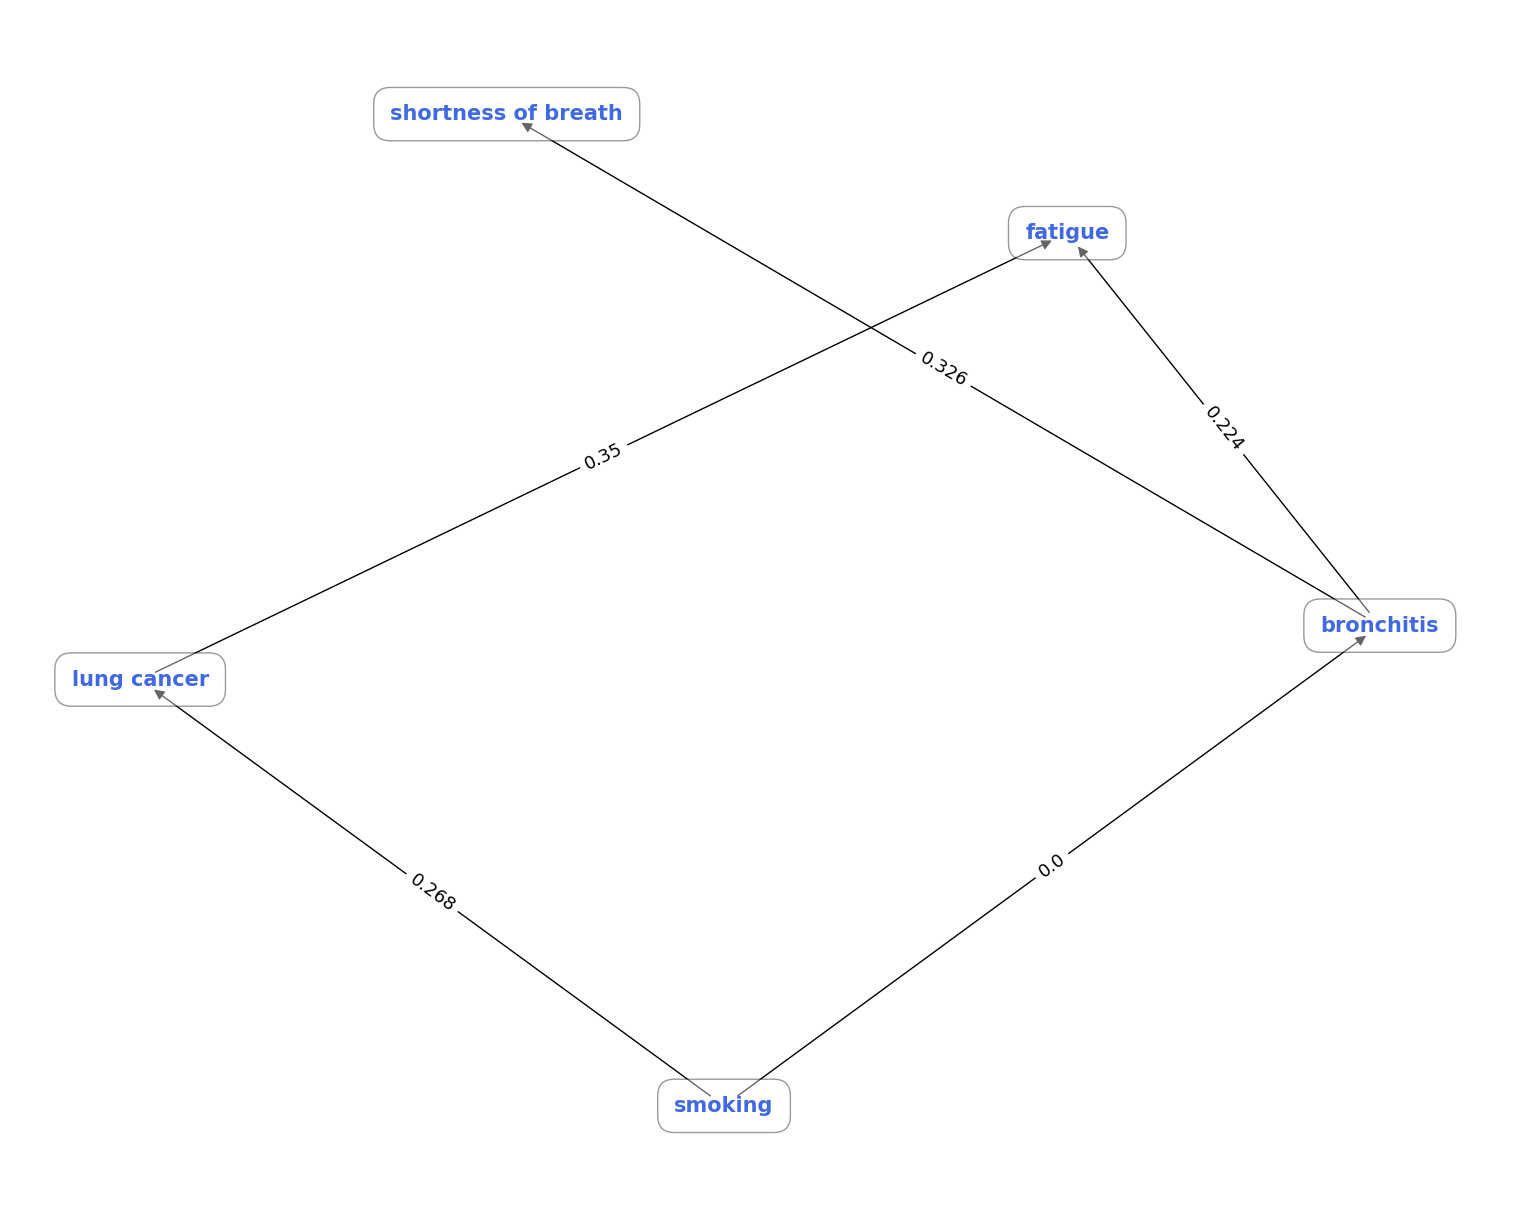

In [86]:
cwg = nx.DiGraph()

cg.add_node("smoking",id = str("smoking"),title=str("smoking"),x=615,y=200)
cg.add_node("bronchitis",id = str("bronchitis"),title=str("bronchitis"),x=615,y=200)
cg.add_node("lung cancer",id = str("lung cancer"),title=str("lung cancer"),x=615,y=200)
cg.add_node("shortness of breath",id = str("shortness of breath"),title=str("shortness of breath"),x=615,y=200)
cg.add_node("fatigue",id = str("fatigue"),title=str("fatigue"),x=615,y=200)

cg.add_edge("smoking", "bronchitis")
cg.add_edge("smoking", "lung cancer")
cg.add_edge("bronchitis", "shortness of breath")
cg.add_edge("bronchitis", "fatigue")
cg.add_edge("lung cancer", "fatigue")

sources = ["smoking","smoking", "bronchitis","bronchitis","lung cancer"]

destinations = ["bronchitis", "lung cancer", "shortness of breath", "fatigue", "fatigue"]

types = ["c","c","c","c","c"]

for s,d,w,t in zip(sources,destinations, weights,types):
    if w < 0:
        w = w * -1
    cwg.add_edge(s, d, predicate=w, nature = t)
    
print("Nodes:",len(cwg.nodes))
print("Edges:",len(cwg.edges))

for e in cwg.edges(data=True):
    print(e[0],",",e[2],",",e[1])
    

pos = nx.spring_layout(cwg, k=4, iterations=20)
plt.figure(figsize=(15,12))

nx.draw(cwg, pos=pos, with_labels=True,  node_shape="s",  node_color="none", font_size=15,  font_color='royalblue', font_weight='bold',bbox=dict(facecolor="white", alpha=0.4,boxstyle='round,pad=0.8'),labels={node: node for node in cwg.nodes()},arrows=True, arrowsize=15,width=1)
edge_labels = nx.get_edge_attributes(cwg,'predicate')
#edge_labels2 = nx.get_edge_attributes(cwg,'polarity')
#edge_labels3 = nx.get_edge_attributes(cwg,'weight')

nx.draw_networkx_edge_labels(cwg, pos=pos, edge_labels = edge_labels, font_color='black',font_size=13)

plt.axis('off')
plt.show()

In [87]:
def FromTruthTable(i,inputs):
    count = 0

    if inputs==1:
        for a in range(1, -1, -1):
            if i == count:
                return (a)
            count = count+1

    if inputs==2:
        for a in range(1, -1, -1):
            for b in range(1, -1, -1):
                if i == count:
                    t = (a,b)
                    return t
                count = count+1
        
    elif inputs==3:
        for a in range(1, -1, -1):
            for b in range(1, -1, -1):
                for c in range(1, -1, -1):
                    if i == count:
                        t = (a,b,c)
                        return t
                    count = count+1
    
    elif inputs==4:
        for a in range(1, -1, -1):
            for b in range(1, -1, -1):
                for c in range(1, -1, -1):
                    for d in range(1, -1, -1):
                        if i == count:
                            t = (a,b,c,d)
                            return t
                        count = count+1

    elif inputs==5:
        for a in range(1, -1, -1):
            for b in range(1, -1, -1):
                for c in range(1, -1, -1):
                    for d in range(1, -1, -1):
                        for e in range(1,-1,-1):
                            if i == count:
                                t = (a,b,c,d,e)
                                return t
                            count = count+1
                            
    elif inputs==6:
        for a in range(1, -1, -1):
            for b in range(1, -1, -1):
                for c in range(1, -1, -1):
                    for d in range(1, -1, -1):
                        for e in range(1,-1,-1):
                            for f in range(1,-1,-1):
                                if i == count:
                                    t = (a,b,c,d,e,f)
                                    return t
                                count = count+1

class Tutorial1:
    #def __init__(self):
    def Add(self, net, id ,name, outcomes, x_pos, y_pos):
        e = self.create_cpt_node(net, id, name, outcomes, x_pos, y_pos)
        nodeNames.append(net.get_node_name(e))
        nodeIds.append(net.get_node_id(e))
        nodeHandles.append(e)
        net.write_file("./GeNie CBN/CBN.xdsl")
        
    def AddArcs(self, net, s, d):
        net.add_arc(s, d)
        net.write_file("./GeNie CBN/CBN.xdsl")

    def Addcpts(self, net, h, cpt):
        net. set_node_definition(h, cpt)
        net.write_file("./GeNie CBN/CBN.xdsl")
        
    def create_cpt_node(self, net, id, name, outcomes, x_pos, y_pos):
        handle = net.add_node(pysmile.NodeType.CPT, id)
        net.set_node_name(handle, name)
        net.set_node_position(handle, x_pos, y_pos, 85, 55)
        initial_outcome_count = net.get_outcome_count(handle)
        for i in range(0, initial_outcome_count):
            net.set_outcome_id(handle, i, outcomes[i])
        for i in range(initial_outcome_count, len(outcomes)):
            net.add_outcome(handle, outcomes[i])
        return handle
    
    def print_cpt_matrix(self, net, node_handle):
        cpt = net.get_node_definition(node_handle)
        return cpt
    

net = pysmile.Network()
obj = Tutorial1()
outcomes = ["True","False"]
nodeNames = []    
nodeIds = []
nodeHandles = []
# cpts=[]
PDs = []
baseline = 0.1
x = 160
y = 40

for node in cwg.nodes: 
    obj.Add(net, str(node),str(node), outcomes, x, y)
        
for e in cwg.edges():
    for id,name in zip(nodeIds,nodeNames):
        if name == e[0]:
            s = id
        if name == e[1]:
            d = id 
    obj.AddArcs(net, s, d)
    
for handle,name in zip(nodeHandles,nodeNames): 
    print("Handle:" + str(handle))
    print("Node:" + name)
    print(net.get_outcome_ids(handle))
    parent_ids = net.get_parent_ids(handle)
    num_parents = len(parent_ids)
    print("Number of Parents:" + str(num_parents))
    cpt = []
    parent_names = []
    totalCols = 1
    if num_parents == 0:
        cpt.append(baseline)
        cpt.append(1 - baseline)
        print("CPT:" + str(cpt))
        obj.Addcpts(net, handle, cpt)
        print("CPT from Network:")
        print(obj.print_cpt_matrix(net, handle))
        print("********************************************************************")
    elif num_parents > 0:
        for par in parent_ids:
                parent_names.append(net.get_node_name(par))
                totalCols = 2 ** num_parents
        print("Names of Parents:" + str(parent_names))
        print("totalCols:" + str(totalCols))
        for j in range(0, totalCols):
            print("j: "+str(j))
            PI = 1
            NI = 1
            ans = FromTruthTable(j,num_parents)
            print("From Dummy: "+str(ans))
            #for parent in parent_names:
            for p in range(0,len(parent_names)):
                for edge in cwg.edges(data=True):
                    if str(parent_names[p]) == str(edge[0]) and str(name) == str(edge[1]):
                        for nbr, eattr in edge[2].items():
                            if nbr == "predicate":
                                polarity = eattr
                            if nbr == "nature":
                                n = eattr
                        break
                print("Parent: " + parent_names[p])
                print("Polarity: " + str(polarity))
                print("p: "+str(p))
                if num_parents > 1:
                    if ans[p] == 0:
                        polarity = 0
                        print("New Polarity: " + str(polarity))
                else:
                    if ans == 0:
                        polarity = 0
                        print("New Polarity: " + str(polarity))
                #if polarity >= 0:
                    #polarity = polarity/4
                    #PI = PI * (1 - polarity)
                #else:
                    #polarity = polarity/ (-4)
                    #NI = NI * (1 - abs(polarity))
                if n == 'c':
                    PI = PI * (1 - polarity)
                else:
                    NI = NI * (1 - polarity)
            CP = 0
            PI = 1 - (1-baseline) * PI
            NI = NI
            CP = PI * NI  
            #CP = 0
            #if PI > NI:
                #CP = baseline + ((1 - baseline) * AI)
            #elif PI < NI:
                #CP = baseline - (baseline * AI)
            #elif PI == NI:
                #CP = baseline
            if CP == 0:
                CP = 0.01
            cpt.append(round(CP, 3))
            cpt.append(round((1 - CP), 3))
            pds = []
            pds.append(round(CP, 3))
            pds.append(round((1 - CP), 3))
            PDs.append(pds)
        print("CPT:" + str(cpt))
        obj.Addcpts(net, handle, cpt)
        print("CPT from Network:")
        print(obj.print_cpt_matrix(net, handle))
        print("********************************************************************")

Handle:0
Node:smoking
['True', 'False']
Number of Parents:0
CPT:[0.1, 0.9]
CPT from Network:
[0.1, 0.9]
********************************************************************
Handle:1
Node:bronchitis
['True', 'False']
Number of Parents:1
Names of Parents:['smoking']
totalCols:2
j: 0
From Dummy: 1
Parent: smoking
Polarity: 0.0
p: 0
j: 1
From Dummy: 0
Parent: smoking
Polarity: 0.0
p: 0
New Polarity: 0
CPT:[0.1, 0.9, 0.1, 0.9]
CPT from Network:
[0.1, 0.9, 0.1, 0.9]
********************************************************************
Handle:2
Node:lung cancer
['True', 'False']
Number of Parents:1
Names of Parents:['smoking']
totalCols:2
j: 0
From Dummy: 1
Parent: smoking
Polarity: 0.268
p: 0
j: 1
From Dummy: 0
Parent: smoking
Polarity: 0.268
p: 0
New Polarity: 0
CPT:[0.341, 0.659, 0.1, 0.9]
CPT from Network:
[0.341, 0.659, 0.1, 0.9]
********************************************************************
Handle:3
Node:shortness of breath
['True', 'False']
Number of Parents:1
Names of Parents:['b

In [88]:
P = PDs
# Q = PDs
# Set Reference as Original CPT
Q = [[0.6, 0.4], [0.4, 0.6], [0.8, 0.2], [0.2, 0.8], [0.8, 0.2], [0.2, 0.8],[0.9,0.1],[0.6,0.4],[0.7,0.3],[0.1,0.9]]
print(len(P))
print(P)
print(len(Q))
print(Q)

10
[[0.1, 0.9], [0.1, 0.9], [0.341, 0.659], [0.1, 0.9], [0.393, 0.607], [0.1, 0.9], [0.546, 0.454], [0.302, 0.698], [0.415, 0.585], [0.1, 0.9]]
10
[[0.6, 0.4], [0.4, 0.6], [0.8, 0.2], [0.2, 0.8], [0.8, 0.2], [0.2, 0.8], [0.9, 0.1], [0.6, 0.4], [0.7, 0.3], [0.1, 0.9]]


In [89]:
kl = []
for i in range(0,len(P)):
    k = kl_div(Q[i],P[i])
    kl.append(k.sum())

kl = np.array(kl)
kl_divergence = round((kl.sum())/5,3)
print(kl_divergence)

0.519
